### Neshyba 2023


# Oxygenated Graphene


### When a Hamiltonian is not separable
Consider the molecule displayed in Fig. 1, 

<p style='text-align: center;'>
<img src="http://webspace.pugetsound.edu/facultypages/nesh/Notebook/Oxographene.jpg" height="500" width="500"/>
<p style='text-align: center;'>
<strong>Figure 1</strong>. Oxographene, an oxidized form of graphene.
</p>

The presence of that oxygen atom in the lower right has pretty much ruined any hope of 2-d separability. In mathematical terms, what this means is that we can be pretty sure that the Hamiltonian is *not* separable (i.e., $H \not = H_x + H_y$), and therefore the eigenfunctions will *not* be well-described as simple products of 1-d wavefunctions (i.e., $\Psi(x,y) \not = \psi(x)\psi'(y)$. And therefore ... we need a new approach. Sigh.

### Linear algebra to the rescue
It turns out that the kinetic part of the Hamiltonian separates just fine, as suggested by this equation, 

$$
H = -{\hbar^2 \over 2m} \big ( \nabla^2_x +  \nabla^2_y \big ) + V(x,y) \ \ \ \ (1)
$$

In going from a 1-d matrix representation to a 2-d one, the matrices representing these kinetic parts will get much bigger, but it's straightforward enough to implement. We start with the matrix representations of just the 1-d kinetic energy parts (which are the same as what did before, in 1d),

    KEx = -hbar**2/(2*m) * (-2.0*np.diag(np.ones(nx))+np.diag(np.ones(nx-1),1)+np.diag(np.ones(nx-1),-1))/dx**2
    KEy = -hbar**2/(2*m) * (-2.0*np.diag(np.ones(ny))+np.diag(np.ones(ny-1),1)+np.diag(np.ones(ny-1),-1))/dy**2

To combine all these into a new, 2-d matrix representation, we need to use what's called the Kronecker delta. In Python, that functionality is built in. We can make it happen by

    KE = np.kron(KEx,Iy) + np.kron(Ix,KEy)

where we've used identity matrices

    Ix = np.diag(np.ones(nx))
    Iy = np.diag(np.ones(ny))
    
Now, it's true that KE is a lot bigger than KEx or KEy. It's the size of the *outer product* of those, in fact. To take an example, if we had a grid of $nx=60$ points in the x-direction and $ny=50$ points in the y-direction, KE would measure $3000 \times 3000$ (because $60 \times 50 = 3000$). 

On the other hand, it's easy-peasy for even modest computer these days to diagonalize $3000 \times 3000$ matrices.
    
We'll also need the potential energy part of Eq. (1). Let's imagine we have a 2-d array of potential energy values, PE, in which there's a potential energy value for each point in our $60 \times 50$ grid. If we wanted to represent something like the molecule shown in Fig. 1, we'd set most values of that $60 \times 50$ grid to zero, except around the oxygen, where'd we assign negative values. We've done this before, in the case of a conjugated polyene, so we even know how much lower is right: about $0.3 \ hartrees$.

That PE matrix has to get "flattened out" so it makes a diagonal matrix whose dimensions match that of KE. The following code accomplishes that trick pretty compactly,

    PE = np.diag(np.reshape(PE,nx*ny))
    
Then we form our Hamiltonian

    H = KE + PE
    
and diagonalize as before! There will be one more bit of unpacking the wavefunctions, but by this time, we've done  all the heavy lifting.
   
### Learning goals
The main learning goals of this exercise are 
1. ...


In [1]:
import pint; from pint import UnitRegistry; AssignQuantity = UnitRegistry(system='atomic').Quantity
import numpy as np
import scipy.linalg as spla
import matplotlib.pyplot as plt
import PchemLibrary as PL
import plotly.graph_objects as go
%matplotlib notebook

In [2]:
# Quantum constants
hbar = AssignQuantity(1,'atomic_unit_of_time * hartree'); print(hbar)
h = hbar*2*np.pi; print(h)
m = AssignQuantity(1,'atomic_unit_of_mass'); print(m)

1 atomic_unit_of_time * hartree
6.283185307179586 atomic_unit_of_time * hartree
1 electron_mass


### Laying out the x- and y- dimensions

In [3]:
# Specify the width of our oxygenated graphene molecule, and create a grid of points along that width
a = AssignQuantity(8.5,'angstrom'); print(a)
a.ito('bohr')
nx = 60
xvec=np.linspace(0,a,nx)
dx = xvec[1]-xvec[0]

# Similar for the height
### BEGIN SOLUTION
b = AssignQuantity(8,'angstrom'); print(b)
b.ito('bohr')
ny = 50
yvec=np.linspace(0,b,ny)
dy = yvec[1]-yvec[0]
### END SOLUTION

8.5 angstrom
8 angstrom


### Making the kinetic energy matrix

In [4]:
# Matrix that represents the 1-d kinetic energy in the x-direction (just as we did in 1d),
KEx = -hbar**2/(2*m) * (-2.0*np.diag(np.ones(nx))+np.diag(np.ones(nx-1),1)+np.diag(np.ones(nx-1),-1))/dx**2

# Similar for the y (vertical) direction
### BEGIN SOLUTION
KEy = -hbar**2/(2*m) * (-2.0*np.diag(np.ones(ny))+np.diag(np.ones(ny-1),1)+np.diag(np.ones(ny-1),-1))/dy**2
### END SOLUTION

# Make those identity matrices we talked about in the Introduction
### BEGIN SOLUTION
Ix = np.diag(np.ones(nx))
Iy = np.diag(np.ones(ny))
### END SOLUTION

# Combine them into a new, big "outer" matrix (non-dimensional b/c our diagonalizer doesn't like units)
KE = np.kron(KEx.magnitude,Iy) + np.kron(Ix,KEy.magnitude)
print(np.shape(KE))

(3000, 3000)


### Making the potential energy matrix

<IPython.core.display.Javascript object>


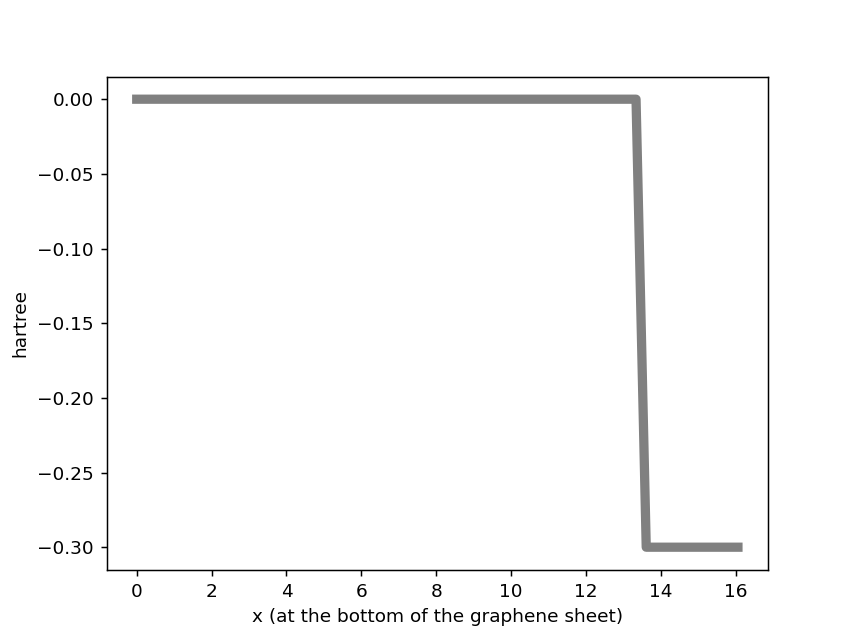

In [5]:
# Modeling our x-y matrix after our conjugated polyene with a terminal oxygen 
PEorig = np.zeros([nx,ny])
PEorig[-10:,-10:] = -0.3
PEorig = AssignQuantity(PEorig,'hartree')

plt.figure()
plt.plot(xvec.magnitude,PEorig[:,-1].magnitude,color='gray',linewidth=5)
plt.xlabel('x (at the bottom of the graphene sheet)')
plt.ylabel(str(PEorig.units))

# This turns it into the big PE matrix (non-dimensional b/c our diagonalizer doesn't like units)
PE = np.diag(np.reshape(PEorig.magnitude,nx*ny))

### Make the Hamiltonian and solve (diagonalize) it
OK, you do the honors here: Construct the Hamiltonian, and use sympy's eigh function to diagonalize it.

In [6]:
### BEGIN SOLUTION
H = KE + PE
Epsi,psi = spla.eigh(H)
### END SOLUTION

### Checking out the eigenfunctions
The code below loops over the first score of eigenfunctions and plots them.

<IPython.core.display.Javascript object>


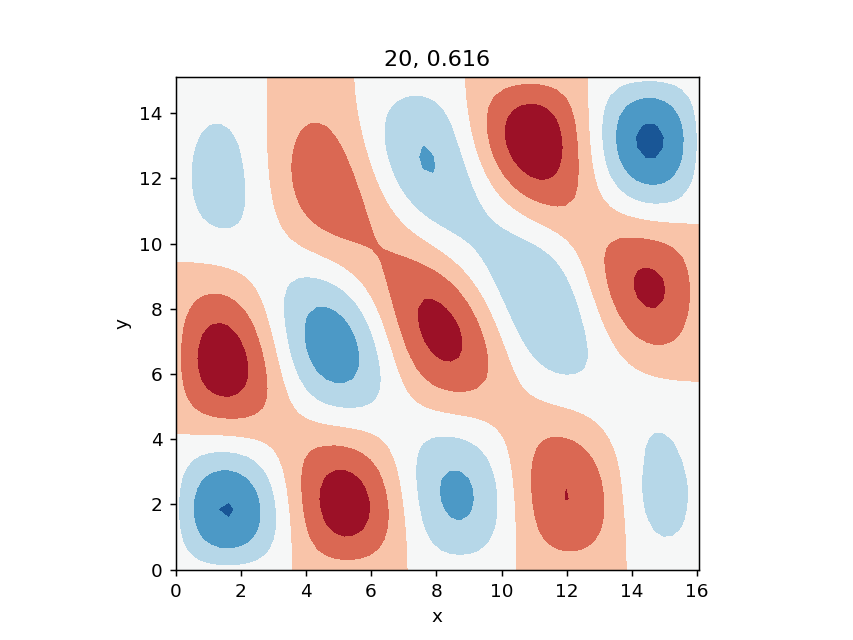

<IPython.core.display.Javascript object>


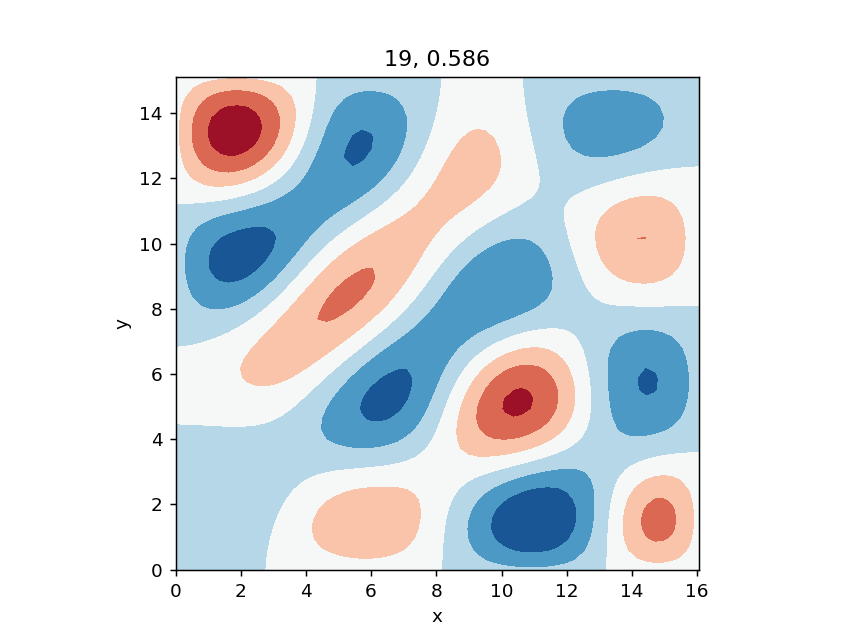

<IPython.core.display.Javascript object>


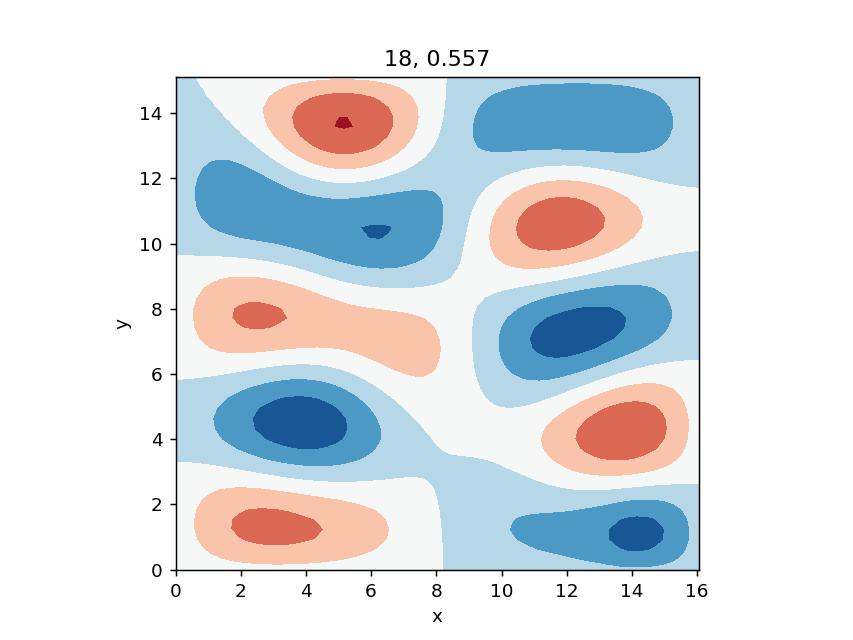

<IPython.core.display.Javascript object>


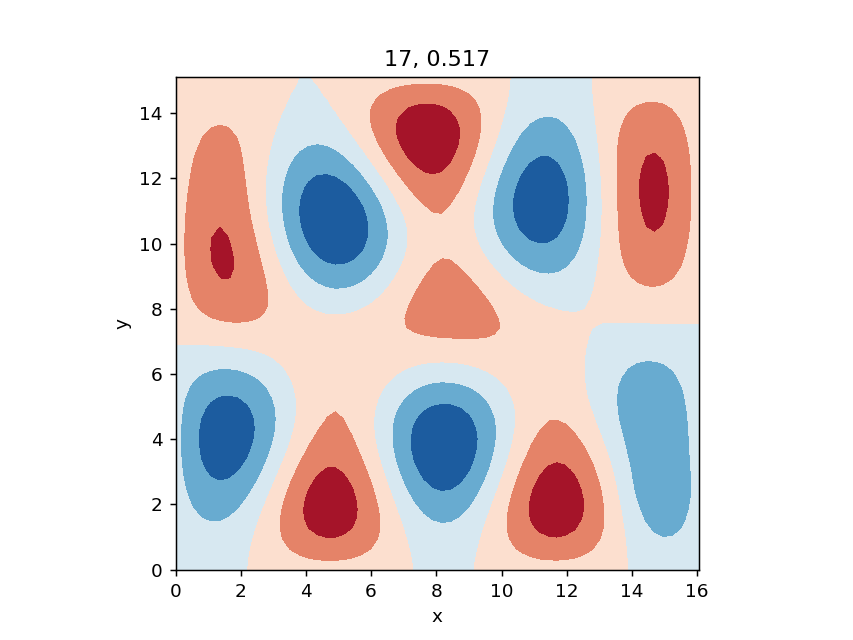

<IPython.core.display.Javascript object>


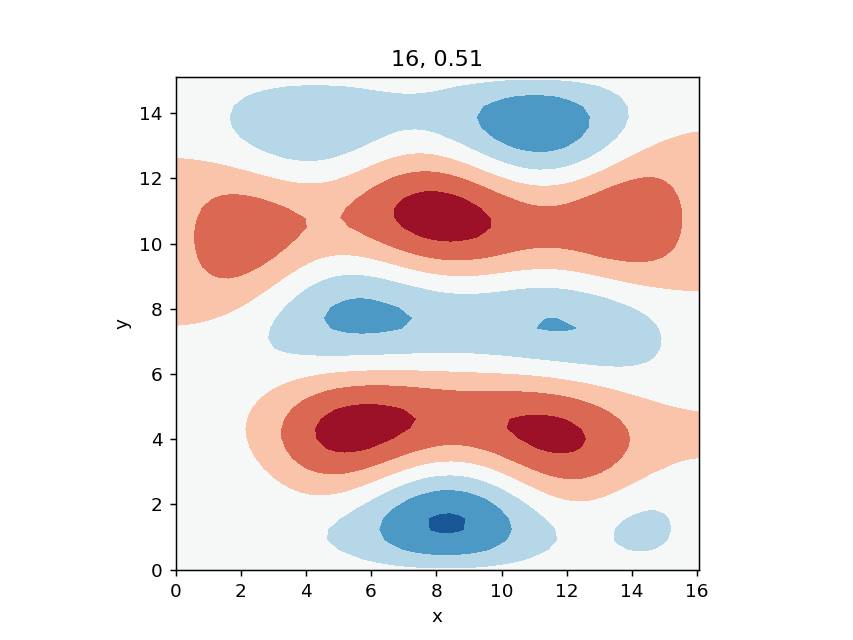

<IPython.core.display.Javascript object>


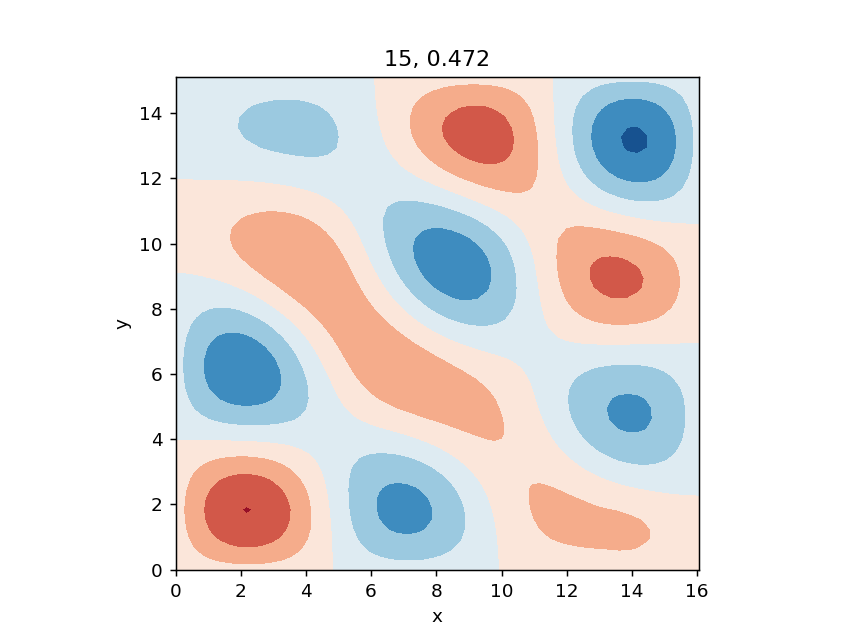

<IPython.core.display.Javascript object>


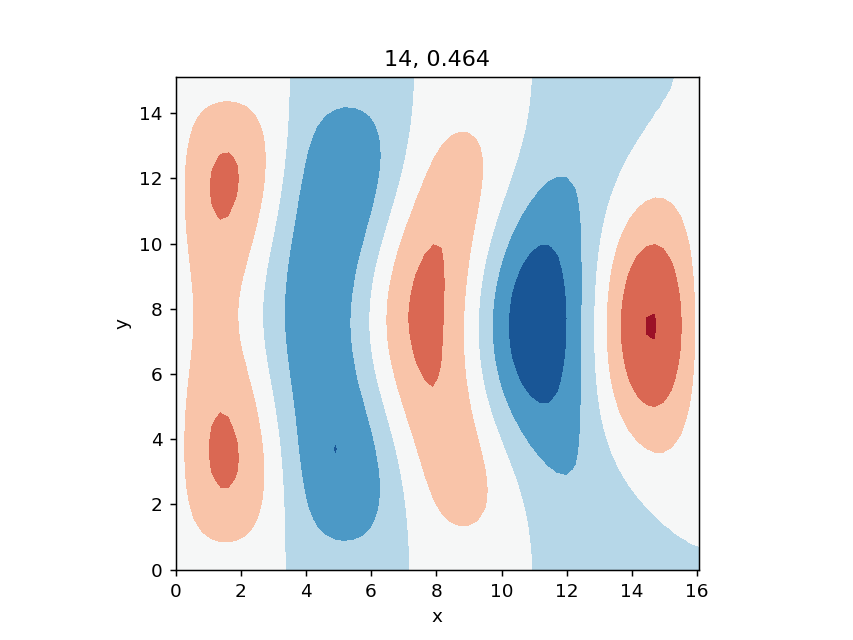

<IPython.core.display.Javascript object>


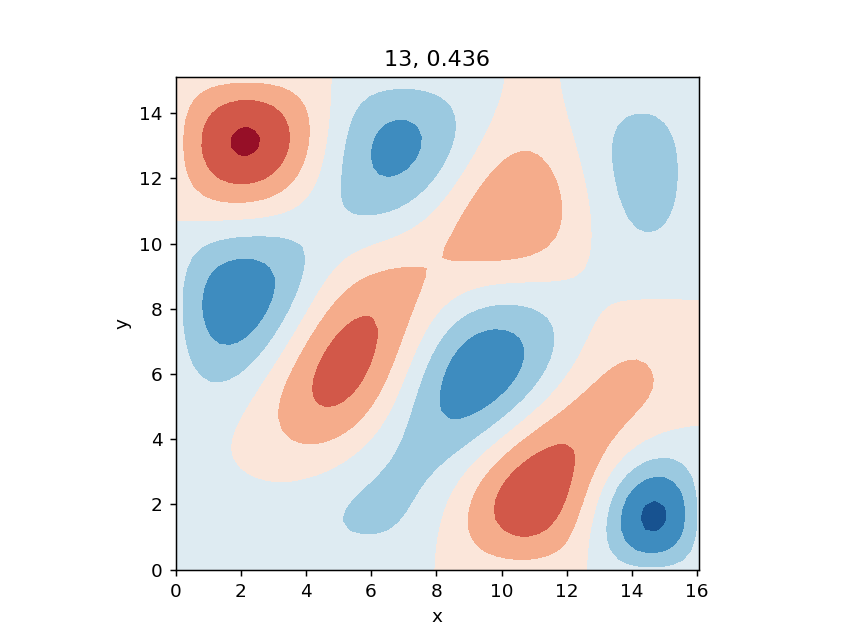

<IPython.core.display.Javascript object>


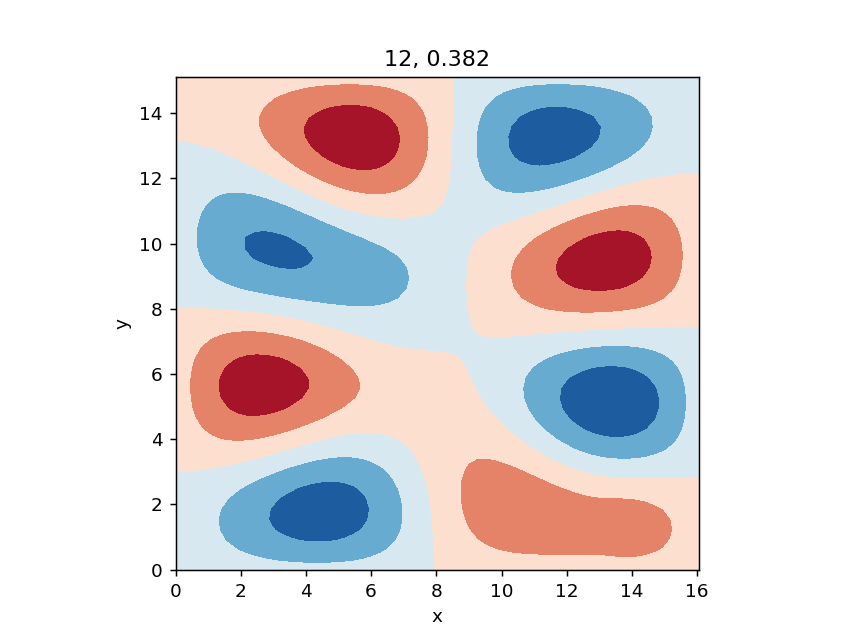

<IPython.core.display.Javascript object>


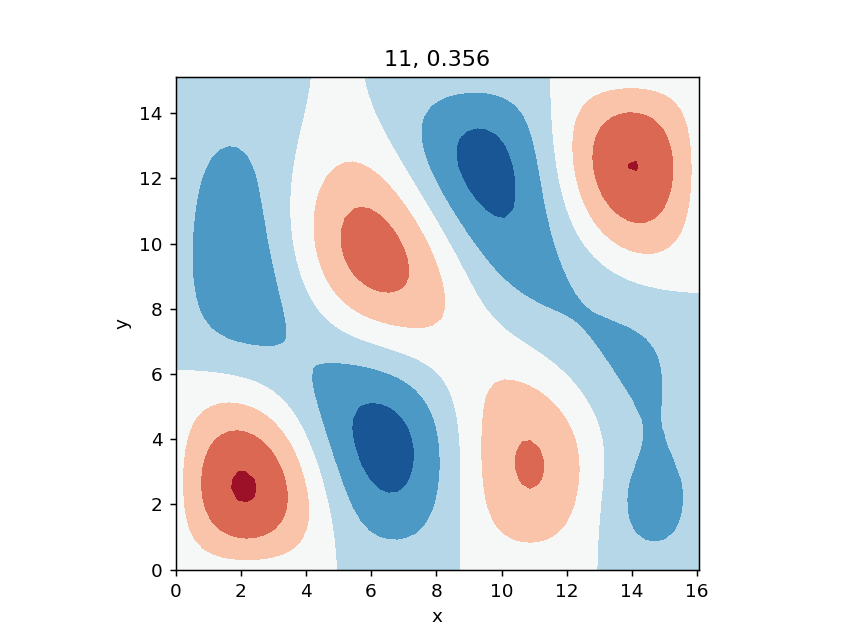

<IPython.core.display.Javascript object>


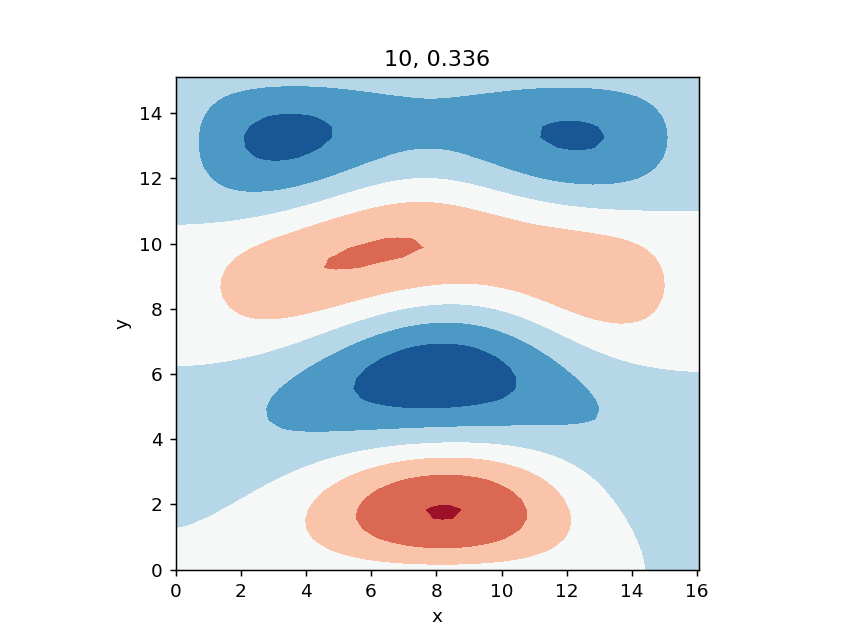

<IPython.core.display.Javascript object>


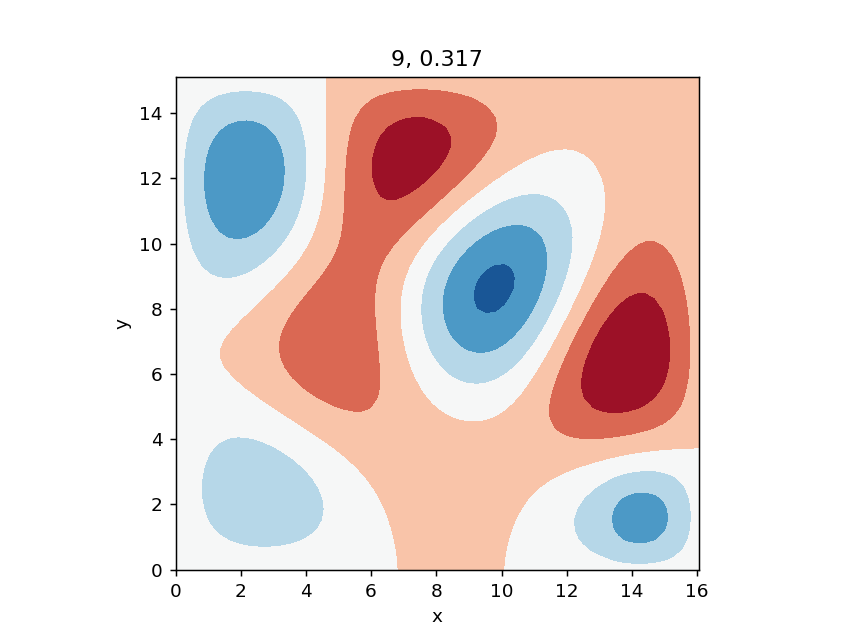

<IPython.core.display.Javascript object>


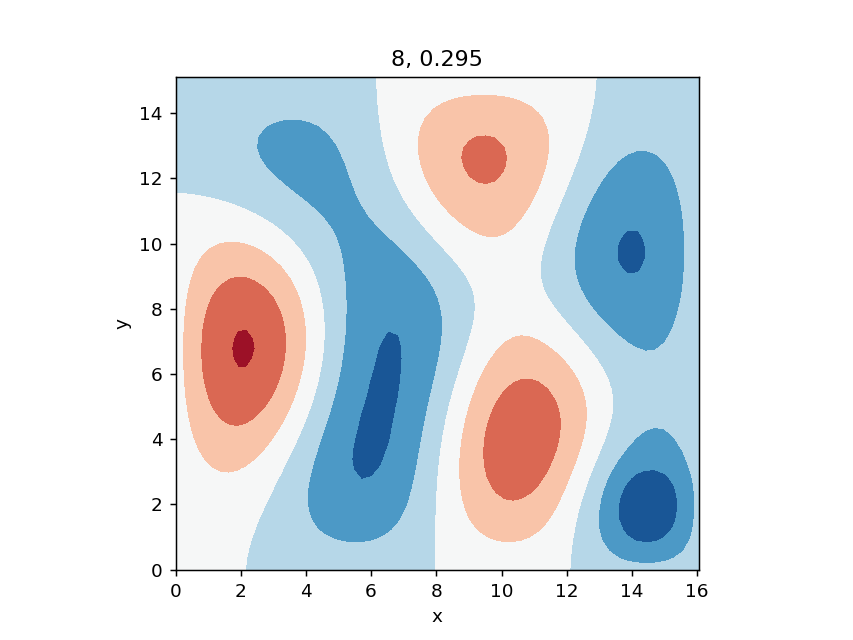

<IPython.core.display.Javascript object>


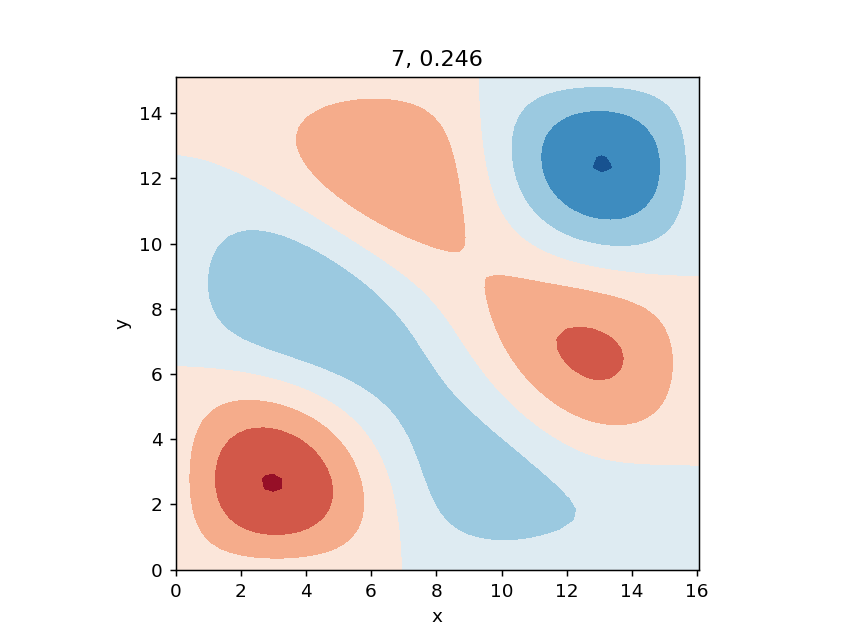

<IPython.core.display.Javascript object>


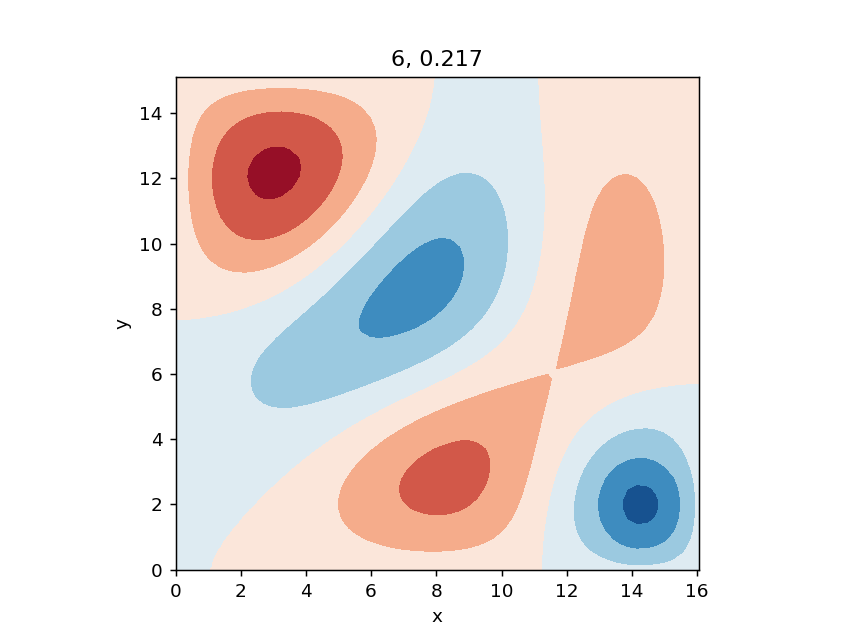

<IPython.core.display.Javascript object>


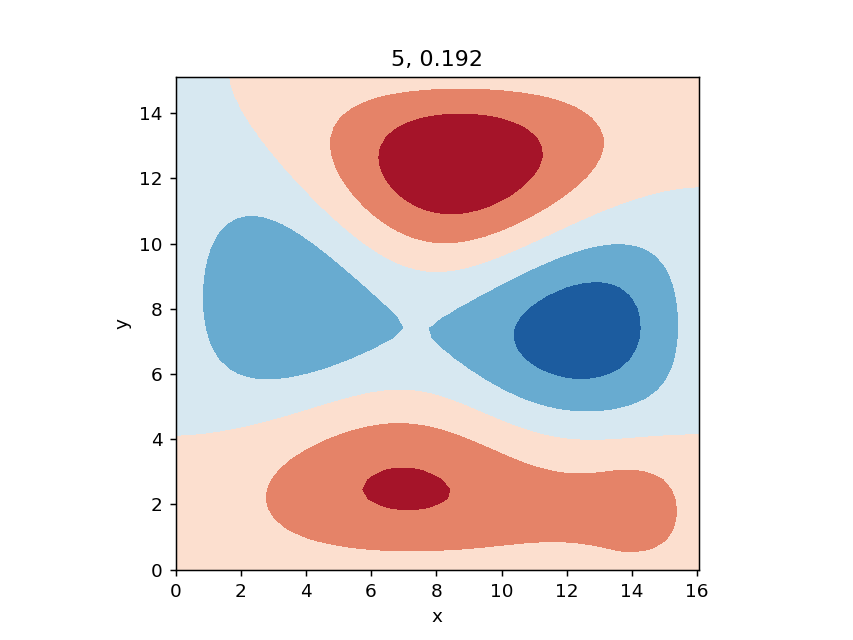

<IPython.core.display.Javascript object>


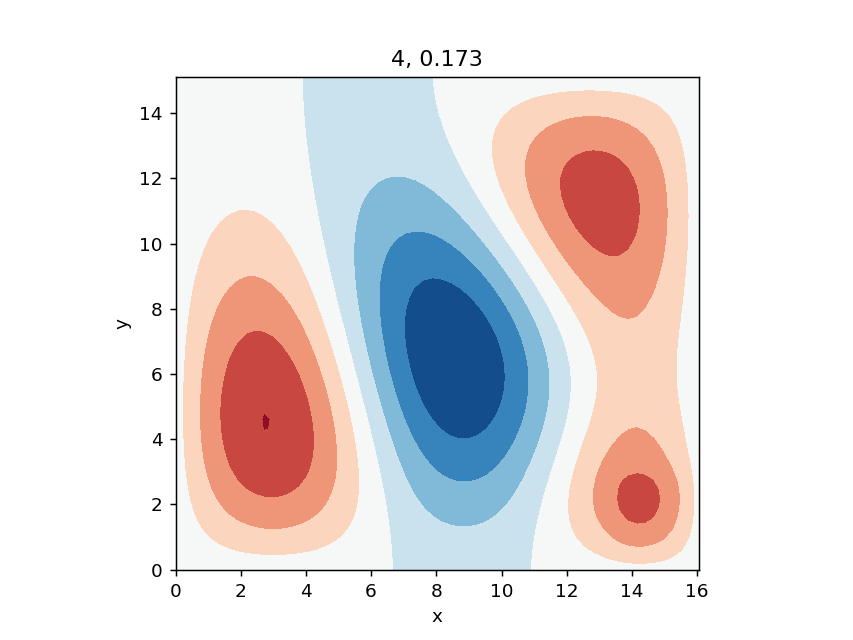

<IPython.core.display.Javascript object>


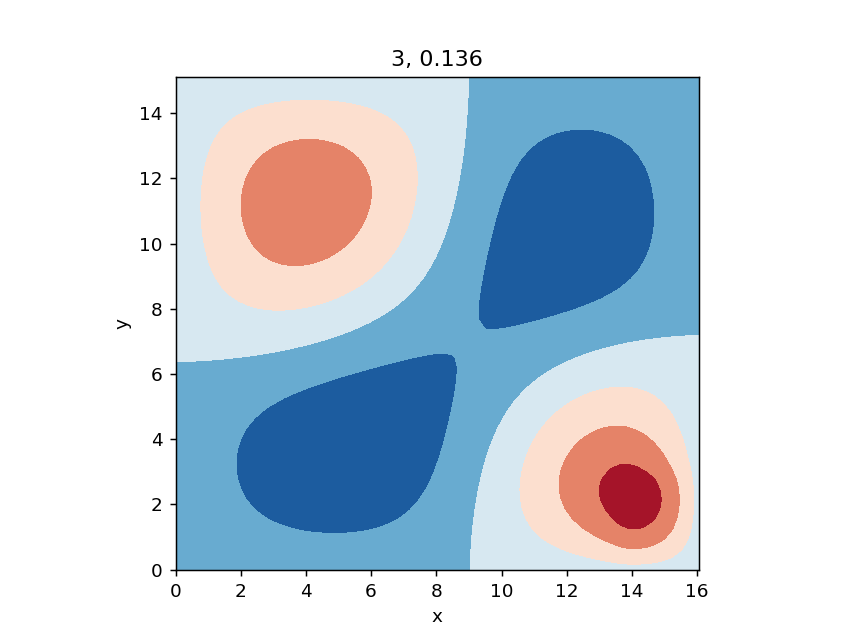

<IPython.core.display.Javascript object>


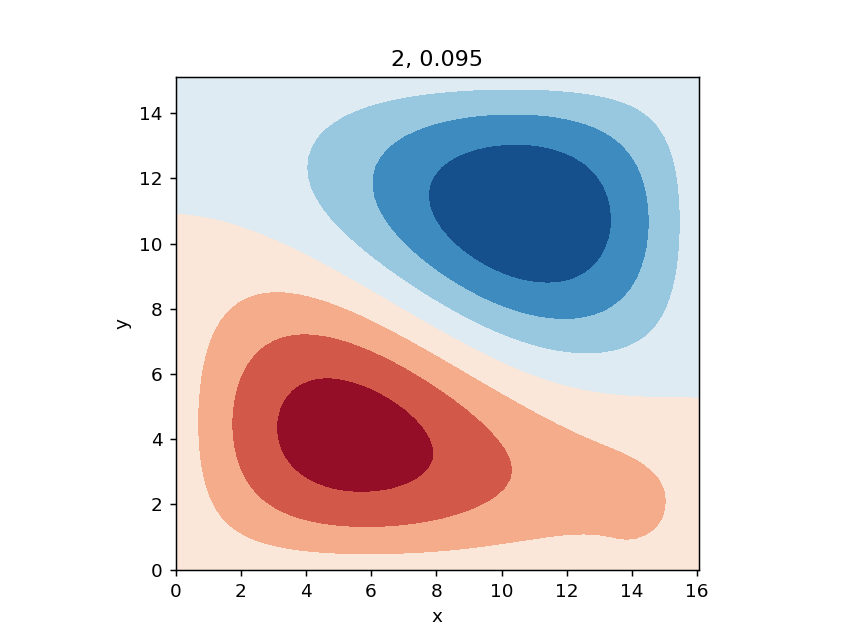

/tmp/ipykernel_12549/556391778.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


<IPython.core.display.Javascript object>


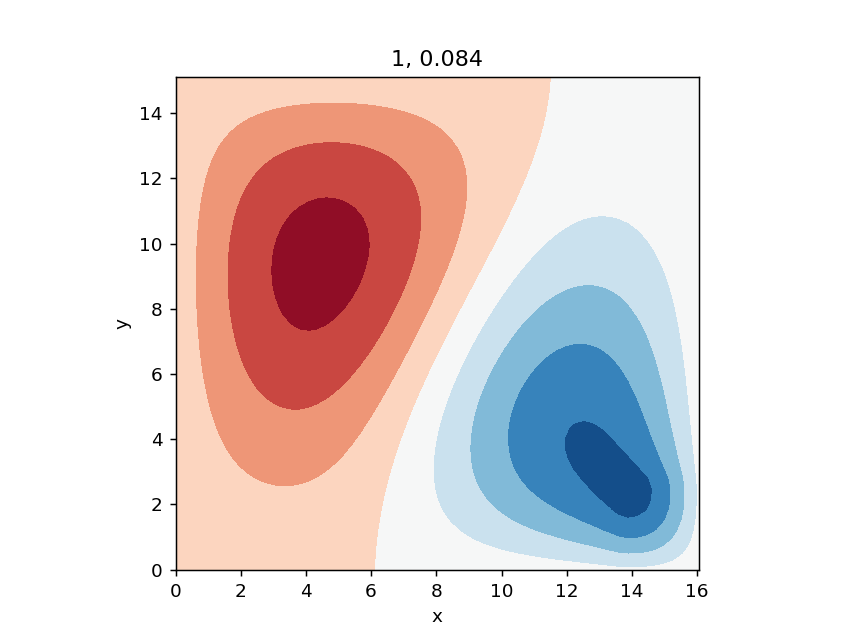

<IPython.core.display.Javascript object>


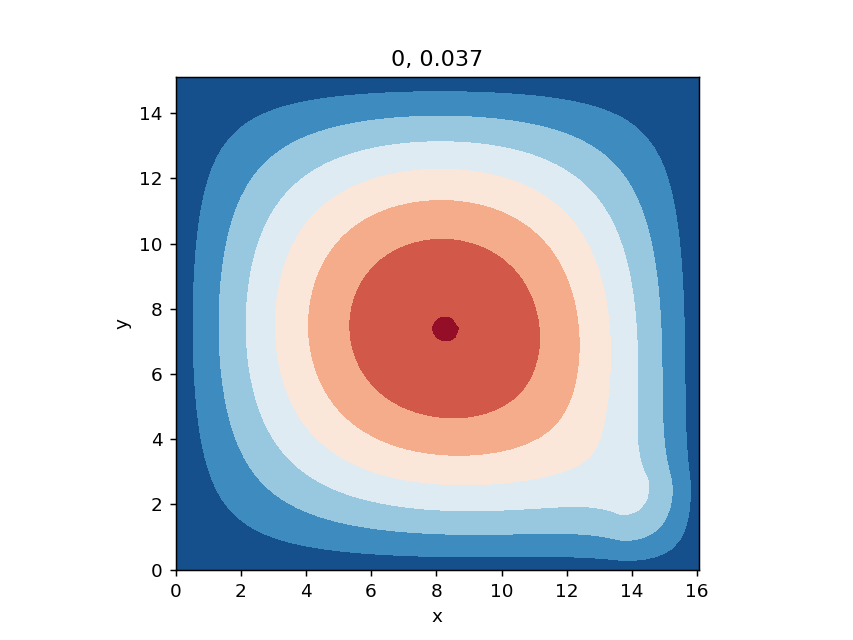

In [8]:
n = 20
for index in range(n,-1,-1):
    Psi_flat = psi[:,index]
    Psi = np.reshape(Psi_flat,[nx,ny]).T
    Psi = np.flipud(Psi) # This is just aesthetic, so the y-coordinate increases from bottom to top
    fig, ax = plt.subplots() 
    ax.contourf(xvec,yvec,Psi,cmap='RdBu')
    plt.title(str(index)+', '+str(round(Epsi[index],3)))
    ax.set_aspect('1')
    plt.xlabel('x')
    plt.ylabel('y')

### Spartan comparison
If you haven't already done it, now is a good time to solve the oxygenated graphene system on Spartan$^{TM}$. After you do so, have a look at the resulting orbitals. You'll notice that the $\pi$-type orbitals (which is almost all of them) seem to come in tilted and non-tilted symmetries: this is especially evident in the lowest-energy orbitals.  At higher energies, we start seeing a mix of tilted and non-tilted symmetries.  

Visual inspection of our Python results, shows that there are corresponding states:

- Our #7, looks like tilted 1x4 (similar to Spartan's HOMO-9)
- Our #10, looks like a non-tilted 1x4 (similar to Spartan's HOMO-7.

In the cell below, locate tilted 1x5 and 2x4 in your Sparta results and here.

### BEGIN SOLUTION

- Spartan's HOMO-5, and our #11, are  *tilted* 1x5. 
- Spartan's HOMO-4, and our #12, are  *tilted* 2x4. 

### END SOLUTION

### That one very localized orbital in Spartan
You'll no doubt have noticed that one, very localized orbital in Spartan, HOMO-3. It's reproduced in Fig. 2 here.

<p style='text-align: center;'>
<img src="http://webspace.pugetsound.edu/facultypages/nesh/Notebook/Oxographene with HOMO-3.jpg" height="500" width="500"/>
<p style='text-align: center;'>
<strong>Figure 2</strong>. HOMO-3 of oxographene.
</p>

The thing is, this is a $\sigma$-type orbital, so you can't expect to fit it in with the analysis you just did, with the tilted and non-tilted $\pi$-type orbitals. And unfortunately, Spartan shows us just this one $\sigma$-type orbital, so we can't tell how it might fit it into a pattern. 

On the other hand, it's very gratifying to see this localization, even if it's just the one orbital, because it tells us that adding an oxygen to graphene has a pretty whopping big localzing effect on $\sigma$-type orbitals -- much more so, it seems, than it has on $\pi$-type orbitals. Care to hazard a guess as to why that might be? Offer some some thoughts (even wild speculations) in the cell below.

### BEGIN SOLUTION

Maybe it is telling us that the greater electronegativity of oxygen is more about its $\sigma$ orbitals than about its $\pi$ orbitals.

### END SOLUTION

### Refreshing and saving your code
1. Use the dropdown menu Kernel/Restart
2. Use the dropdown menu Cell/Run All Above
3. Under the "File" dropdown menu item in the upper left is a disk icon. Press it now to save your work (you can, do this at any time as you're working on an assignment, actually).

### Validating
This step will help ensure that you didn't miss something (although it's not a guarantee). Find the "Validate" button and press it. If there are any errors or warnings, fix them.

### Finishing up
Assuming all this has gone smoothly, carry out three more steps (but read this carefully before starting):
1. Close this notebook using the "File/Close and Halt" dropdown menu
1. Using the Assignments tab, submit this notebook
1. Press the Logout tab of the Home Page